In [90]:
# Packages for neural networks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot
import pandas 
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
# "converting" data
# Upload data
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [4]:
# Get Data for the completed years of 2018, 2019, and 2020
Whole18 = histplot.getData(18, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole19 = histplot.getData(19, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole20 = histplot.getData(20, direct, ASC, 1, 366, np.arange(3, 7), float)

In [132]:
# Have the Data then convert them into hourly data. 
def hourly(weather):
    minute = 0
    Hourly = np.zeros((8760, 4))
    hour = 0
    endminute = 60
    while (minute < len(weather[:, 3]) and hour < 8760):
        temp = np.nanmean(weather[np.arange(minute, endminute), 0])
        relhum = np.nanmean(weather[np.arange(minute, endminute), 1])
        air_p = np.nanmean(weather[np.arange(minute, endminute), 2])
        precip = np.nanmean(weather[np.arange(minute, endminute), 3])
        if (minute+60 < len(weather[:, 3])):
            minute += 60
        if (minute+60 < len(weather[:, 3])):
            endminute += 60
        else:
            endminute = len(weather[:, 3])-1
        Hourly[hour, 0] = temp
        Hourly[hour, 1] = relhum
        Hourly[hour, 2] = air_p
        Hourly[hour, 3] = 60*precip
        hour += 1
    
    return Hourly

In [133]:
hour18 = hourly(Whole18)
hour19 = hourly(Whole19)
hour20 = hourly(Whole20)

In [120]:
hourall = np.concatenate([hour18, hour19, hour20], axis = 0)
print(hourall.shape)

(26280, 4)


In [122]:
new_hour = pandas.DataFrame(hourall)

In [123]:
new_hour = new_hour.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_hour

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-10.955000,45.361667,1.017778,0.0
1,-11.401667,46.405000,1.017877,0.0
2,-11.616667,47.426667,1.018020,0.0
3,-11.930000,48.390000,1.018145,0.0
4,-12.368333,49.235000,1.018128,0.0
...,...,...,...,...
26275,5.088333,42.065000,1.016072,0.0
26276,5.028333,43.433333,1.015270,0.0
26277,4.566667,47.421667,1.014422,0.0
26278,4.046667,50.323333,1.013760,0.0


In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [124]:
values = new_hour.values
print(values)

[[-10.955       45.36166667   1.01777833   0.        ]
 [-11.40166667  46.405        1.01787667   0.        ]
 [-11.61666667  47.42666667   1.01802      0.        ]
 ...
 [  4.56666667  47.42166667   1.01442167   0.        ]
 [  4.04666667  50.32333333   1.01376      0.        ]
 [  3.58        54.32         1.01281833   0.        ]]


In [125]:
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float64')
print(values)
# normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2]], axis=1, inplace=True)
print(reframed.head())

[[-10.955       45.36166667   1.01777833   0.        ]
 [-11.40166667  46.405        1.01787667   0.        ]
 [-11.61666667  47.42666667   1.01802      0.        ]
 ...
 [  4.56666667  47.42166667   1.01442167   0.        ]
 [  4.04666667  50.32333333   1.01376      0.        ]
 [  3.58        54.32         1.01281833   0.        ]]
   var4(t-1)   var1(t)   var2(t)   var3(t)   var4(t)
1  -0.133183 -2.525772 -0.818005  1.196541 -0.133183
2  -0.133183 -2.547769 -0.763203  1.214980 -0.133183
3  -0.133183 -2.579826 -0.711530  1.231061 -0.133183
4  -0.133183 -2.624672 -0.666204  1.228916 -0.133183
5  -0.133183 -2.683841 -0.558209  1.240709 -0.133183


In [126]:
# split into train and test sets
values = reframed.values
print(values)
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[-0.13318332 -2.52577226 -0.8180051   1.19654121 -0.13318332]
 [-0.13318332 -2.54776894 -0.76320291  1.21498009 -0.13318332]
 [-0.13318332 -2.57982612 -0.71152971  1.23106051 -0.13318332]
 ...
 [-0.13318332 -0.89204976 -0.76347111  0.75207838 -0.13318332]
 [-0.13318332 -0.94525103 -0.60782573  0.66695936 -0.13318332]
 [-0.13318332 -0.99299577 -0.39344456  0.54582019 -0.13318332]]
(8760, 1, 4) (8760,) (17519, 1, 4) (17519,)


Epoch 1/50
122/122 - 1s - loss: 0.1662 - val_loss: 0.1230
Epoch 2/50
122/122 - 0s - loss: 0.1374 - val_loss: 0.1230
Epoch 3/50
122/122 - 0s - loss: 0.1357 - val_loss: 0.1194
Epoch 4/50
122/122 - 0s - loss: 0.1328 - val_loss: 0.1175
Epoch 5/50
122/122 - 0s - loss: 0.1327 - val_loss: 0.1166
Epoch 6/50
122/122 - 0s - loss: 0.1313 - val_loss: 0.1155
Epoch 7/50
122/122 - 0s - loss: 0.1304 - val_loss: 0.1183
Epoch 8/50
122/122 - 0s - loss: 0.1321 - val_loss: 0.1202
Epoch 9/50
122/122 - 0s - loss: 0.1311 - val_loss: 0.1160
Epoch 10/50
122/122 - 0s - loss: 0.1312 - val_loss: 0.1163
Epoch 11/50
122/122 - 0s - loss: 0.1308 - val_loss: 0.1153
Epoch 12/50
122/122 - 0s - loss: 0.1311 - val_loss: 0.1173
Epoch 13/50
122/122 - 0s - loss: 0.1299 - val_loss: 0.1151
Epoch 14/50
122/122 - 0s - loss: 0.1301 - val_loss: 0.1142
Epoch 15/50
122/122 - 0s - loss: 0.1298 - val_loss: 0.1141
Epoch 16/50
122/122 - 0s - loss: 0.1302 - val_loss: 0.1149
Epoch 17/50
122/122 - 1s - loss: 0.1312 - val_loss: 0.1161
Epoch 

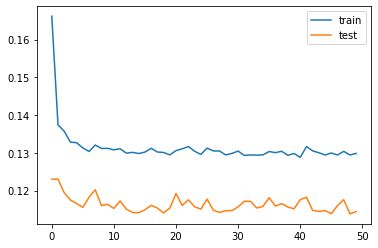

In [127]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [128]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[[-0.01000888 -0.68640636  1.50362317 -0.23075692]
 [ 0.14675859 -0.66270451  1.52811877 -0.4783954 ]
 [ 5.14092232 -0.64838109  1.54197577 -0.75283458]
 ...
 [-0.13318332 -0.89204976 -0.76347111  0.75207838]
 [-0.13318332 -0.94525103 -0.60782573  0.66695936]
 [-0.13318332 -0.99299577 -0.39344456  0.54582019]]
[[-0.06482574 -0.68640636  1.50362317 -0.23075692]
 [ 0.02796724 -0.66270451  1.52811877 -0.4783954 ]
 [ 2.11833477 -0.64838109  1.54197577 -0.75283458]
 ...
 [-0.13334514 -0.89204976 -0.76347111  0.75207838]
 [-0.13349789 -0.94525103 -0.60782573  0.66695936]
 [-0.1337063  -0.99299577 -0.39344456  0.54582019]]
[[12.65212114 48.85836974  1.02026375 -0.08713736]
 [13.55909838 49.30023875  1.02045416 -0.30828902]
 [33.9907724  49.5672675   1.02056188 -0.55337485]
 ...
 [11.98239864 45.02459978  1.00264065  0.79057625]
 [11.98090561 44.03277869  1.00385055  0.71456135]
 [11.97886859 43.14268285  1.00551703  0.60637893]]
Test RMSE: 8.630


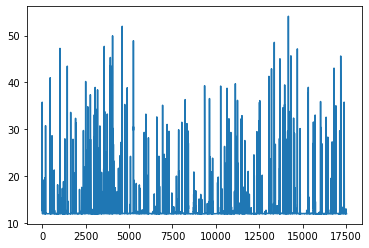

In [129]:
plt.plot(inv_yhat)

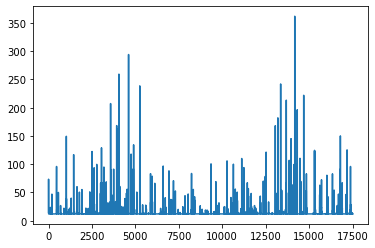

In [130]:
plt.plot(inv_y)

In [47]:
train_X.shape[2]

4

In [49]:
test_X.shape

(17519, 4)

3125.7


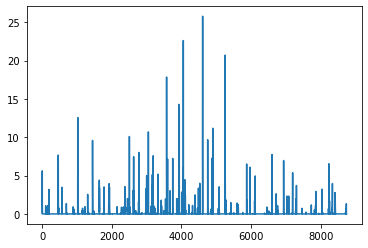

In [135]:
plt.plot(hourall[8760:17499,3])
print(np.sum(hourall[:, 3]))

In [118]:
print(np.sum(hour18))


683721.7383250283


In [136]:
Whole_all = np.concatenate([Whole18, Whole19, Whole20], axis = 0)
Whole_all.shape

(1578191, 4)

In [137]:
new_minute = pandas.DataFrame(Whole_all)

In [138]:
new_minute = new_minute.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_minute

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-11.1,45.5,1.0177,0.0
1,-11.1,45.3,1.0177,0.0
2,-11.1,45.1,1.0177,0.0
3,-11.1,46.2,1.0177,0.0
4,-11.1,45.4,1.0177,0.0
...,...,...,...,...
1578186,4.9,61.2,1.0173,0.0
1578187,4.9,60.8,1.0174,0.0
1578188,4.9,60.7,1.0174,0.0
1578189,4.9,61.3,1.0174,0.0


In [139]:
values = new_minute.values
print(values)

[[-11.1     45.5      1.0177   0.    ]
 [-11.1     45.3      1.0177   0.    ]
 [-11.1     45.1      1.0177   0.    ]
 ...
 [  4.9     60.7      1.0174   0.    ]
 [  4.9     61.3      1.0174   0.    ]
 [  4.9     60.1      1.0175   0.    ]]


In [140]:
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

# normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2]], axis=1, inplace=True)
print(reframed.head())

   var4(t-1)   var1(t)   var2(t)   var3(t)   var4(t)
1  -0.082661 -2.493391 -0.874850  1.173592 -0.082661
2  -0.082661 -2.493391 -0.885543  1.173592 -0.082661
3  -0.082661 -2.493391 -0.826731  1.173592 -0.082661
4  -0.082661 -2.493391 -0.869503  1.173592 -0.082661
5  -0.082661 -2.493391 -0.848117  1.173592 -0.082661


In [141]:
# split into train and test sets
values = reframed.values
print(values)
n_train_hours = 365 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[-0.08266056 -2.4933912  -0.87484996  1.17359217 -0.08266056]
 [-0.08266056 -2.4933912  -0.88554299  1.17359217 -0.08266056]
 [-0.08266056 -2.4933912  -0.82673136  1.17359217 -0.08266056]
 ...
 [-0.08266056 -0.8569745  -0.05148719  1.1349994  -0.08266056]
 [-0.08266056 -0.8569745  -0.01940812  1.1349994  -0.08266056]
 [-0.08266056 -0.8569745  -0.08356626  1.14786365 -0.08266056]]
(525600, 1, 4) (525600,) (1052404, 1, 4) (1052404,)


Epoch 1/50
7300/7300 - 22s - loss: 0.0648 - val_loss: 0.0829
Epoch 2/50
7300/7300 - 21s - loss: 0.0561 - val_loss: 0.0598
Epoch 3/50
7300/7300 - 20s - loss: 0.0528 - val_loss: 0.0656
Epoch 4/50
7300/7300 - 21s - loss: 0.0491 - val_loss: 0.0436
Epoch 5/50
7300/7300 - 25s - loss: 0.0472 - val_loss: 0.0497
Epoch 6/50
7300/7300 - 24s - loss: 0.0450 - val_loss: 0.0419
Epoch 7/50
7300/7300 - 24s - loss: 0.0446 - val_loss: 0.0493
Epoch 8/50
7300/7300 - 20s - loss: 0.0435 - val_loss: 0.0505
Epoch 9/50
7300/7300 - 23s - loss: 0.0432 - val_loss: 0.0468
Epoch 10/50
7300/7300 - 25s - loss: 0.0428 - val_loss: 0.0448
Epoch 11/50
7300/7300 - 23s - loss: 0.0422 - val_loss: 0.0417
Epoch 12/50
7300/7300 - 20s - loss: 0.0422 - val_loss: 0.0419
Epoch 13/50
7300/7300 - 23s - loss: 0.0418 - val_loss: 0.0399
Epoch 14/50
7300/7300 - 20s - loss: 0.0421 - val_loss: 0.0388
Epoch 15/50
7300/7300 - 21s - loss: 0.0418 - val_loss: 0.0384
Epoch 16/50
7300/7300 - 20s - loss: 0.0417 - val_loss: 0.0407
Epoch 17/50
7300/

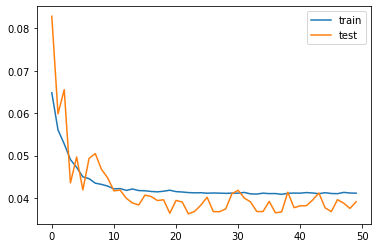

In [142]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [143]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[[-0.08266056 -0.68310523  1.47761511 -0.12569781]
 [-0.08266056 -0.68310523  1.46692209 -0.13856207]
 [-0.08266056 -0.69333283  1.4722686  -0.13856207]
 ...
 [-0.08266056 -0.8569745  -0.05148719  1.1349994 ]
 [-0.08266056 -0.8569745  -0.01940812  1.1349994 ]
 [-0.08266056 -0.8569745  -0.08356626  1.14786365]]
[[-0.08124775 -0.68310523  1.47761511 -0.12569781]
 [-0.08117543 -0.68310523  1.46692209 -0.13856207]
 [-0.08122083 -0.69333283  1.4722686  -0.13856207]
 ...
 [-0.08285032 -0.8569745  -0.05148719  1.1349994 ]
 [-0.08285476 -0.8569745  -0.01940812  1.1349994 ]
 [-0.08288544 -0.8569745  -0.08356626  1.14786365]]
[[ 1.24846378e+01  4.88863523e+01  1.02006332e+00 -1.03385567e-03]
 [ 1.24853449e+01  4.88863523e+01  1.01998019e+00 -1.34288530e-03]
 [ 1.24849011e+01  4.86950573e+01  1.02002175e+00 -1.34288530e-03]
 ...
 [ 1.24689687e+01  4.56343388e+01  1.00817687e+00  2.92510477e-02]
 [ 1.24689253e+01  4.56343388e+01  1.00842624e+00  2.92510477e-02]
 [ 1.24686254e+01  4.56343388e+01  1

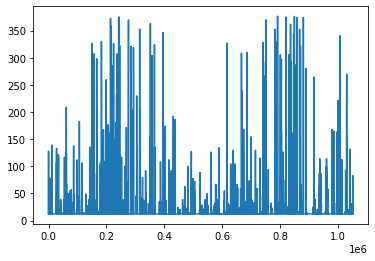

In [145]:
plt.plot(inv_yhat)


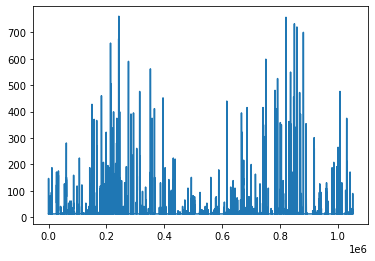

In [146]:
plt.plot()

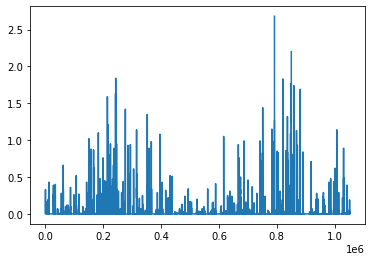

In [147]:
plt.plot(Whole_all[365 * 24 * 60:, 3])

In [149]:
inv_y = inv_y - min(inv_y)


In [151]:
len(inv_y)

1052404

In [154]:
len(Whole_all[525787:, 3])

1052404

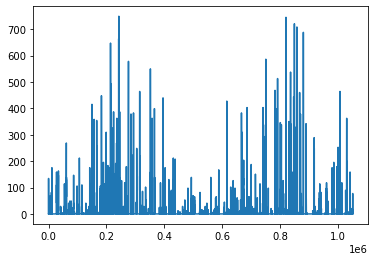

In [150]:
plt.plot(inv_y)

In [158]:
factor = np.divide(inv_y, Whole_all[525787:, 3], where= ((inv_y!=0) & (Whole_all[525787:, 3]!=0)) )

In [159]:
min(factor)

0.0

In [160]:
max(factor)

58610.1953883601

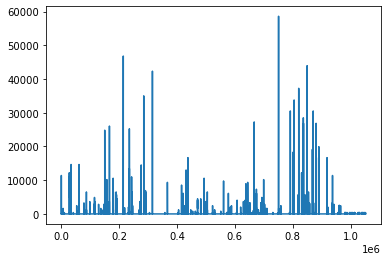

In [161]:
plt.plot(factor)

In [163]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]/1000
# calculate RMSE
inv_yhat = inv_yhat/1000
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.005


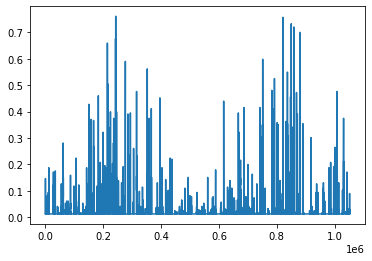

In [164]:
plt.plot(inv_y)